In [18]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F

In [19]:
u1_images=[]
u1_masks=[]
for f in os.listdir("train_u2/"):
    if f.startswith("im_"):
        u1_images.append(np.asarray(Image.open("train_u2/"+f)))
        u1_masks.append(np.asarray(Image.open("train_u2/"+f.replace("im_","mask_"))))

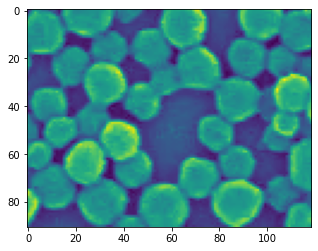

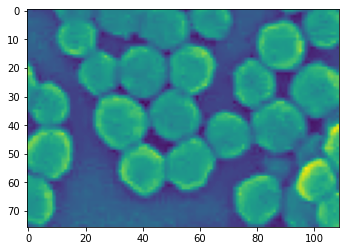

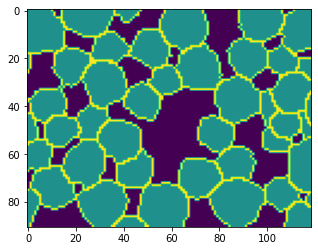

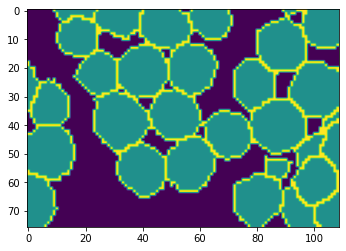

In [20]:
u1_images=[i.mean(axis=2) if len(i.shape)>2 else i for i in u1_images]
for i in u1_images:
    plt.imshow(i)
    plt.show()
    plt.close()

u1_masks=[i.argmax(2) if len(i.shape)>2 else i for i in u1_masks]
for i in u1_masks:
    plt.imshow(i)
    plt.show()
    plt.close()

In [13]:
class Unet(pl.LightningModule):
    def __init__(self, n_channels,n_classes):
        super(Unet, self).__init__()
        self.save_hyperparameters()

        self.n_channels = self.hparams.n_channels
        self.n_classes = self.hparams.n_classes
        self.bilinear = True

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001, weight_decay=1e-8)
model=Unet(n_channels=1,n_classes=3)

In [29]:

train_loader=torch.utils.data.DataLoader([
    (u1_images[i][None,:].astype(np.float32),u1_masks[i]) for i in range(len(u1_masks))
])

In [30]:
trainer = pl.Trainer(gpus=1)
trainer.fit(model,train_dataloader=train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | inc   | Sequential | 37.8 K
1 | down1 | Sequential | 221 K 
2 | down2 | Sequential | 886 K 
3 | down3 | Sequential | 3.5 M 
4 | down4 | Sequential | 4.7 M 
5 | up1   | up         | 3.0 M 
6 | up2   | up         | 738 K 
7 | up3   | up         | 184 K 
8 | up4   | up         | 110 K 
9 | out   | Conv2d     | 195   
-------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.577    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

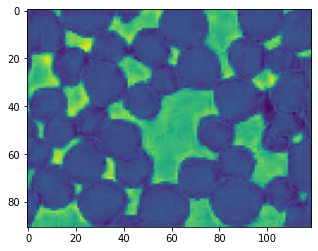

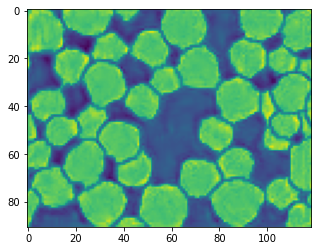

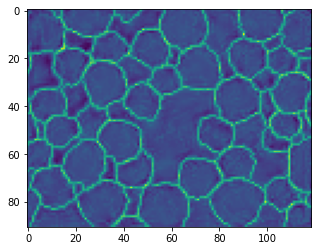

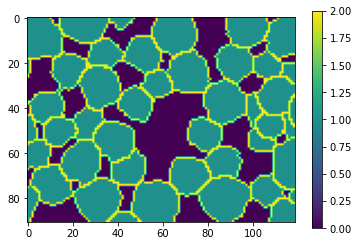

In [31]:
pred = model(torch.from_numpy(u1_images[0][None,None,:].astype(np.float32)))
pred_np=pred.detach().numpy()
for i in pred_np[0]:
    plt.imshow(i)
    plt.show()
    plt.close()
    
plt.imshow(pred_np[0].argmax(0))
plt.colorbar()
plt.show()
plt.close()

In [154]:
def convolution2d(image, kernel, stride, padding,pool=np.sum,constant_values=0):
    if pool==np.min:
        constant_values=image.max()
        
    image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=constant_values)

    kernel_height, kernel_width = kernel.shape
    padded_height, padded_width = image.shape

    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1

    new_image = np.zeros((output_height, output_width)).astype(np.float32)

    for y in range(0, output_height):
        for x in range(0, output_width):
            new_image[y][x] = pool(image[y * stride:y * stride + kernel_height, x * stride:x * stride + kernel_width] * kernel).astype(np.float32)
    return new_image

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

In [ ]:
image = u1_images[0]#to_pred#
mask = u1_masks[0]#pred_np

xc,yc=image.shape[0],image.shape[1]
all_dists=np.zeros((xc*2+1,yc*2+1))
for x in range(all_dists.shape[0]):
    for y in range(all_dists.shape[1]):
        all_dists[x,y]=np.abs(np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc)))
whatershed=np.zeros_like(image,dtype=float)

for x in range(whatershed.shape[0]):
    for y in range(whatershed.shape[1]):
        tm=all_dists[xc-x:xc-x+image.shape[0],yc-y:yc-y+image.shape[1]]
        whatershed[x,y]=tm[~(mask==1)].min()

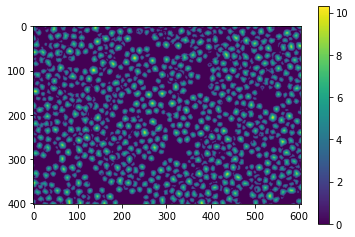

In [552]:
image = to_pred#u1_images[0]#
mask = pred_np#u1_masks[0]#

xc,yc=image.shape[0],image.shape[1]
all_dists=np.zeros((xc*2+1,yc*2+1))
for x in range(all_dists.shape[0]):
    for y in range(all_dists.shape[1]):
        all_dists[x,y]=np.abs(np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc)))
whatershed=np.zeros_like(image,dtype=float)

for x in range(whatershed.shape[0]):
    for y in range(whatershed.shape[1]):
        tm=all_dists[xc-x:xc-x+image.shape[0],yc-y:yc-y+image.shape[1]].copy()
        whatershed[x,y]=tm[~(mask==1)].min()

whatershed[whatershed==1]=0

plt.imshow(whatershed)
plt.colorbar()
plt.show()
plt.close()

In [553]:
def flood_mask(image,x,y,check):
    stack=[]
    
    new_stack=[(x,y)]
    checked=np.zeros_like(image).astype(bool)
    mask=np.zeros_like(image).astype(bool)
    
    while len(new_stack)>0:
        #print(len(new_stack),checked.sum())
        nx,ny = new_stack.pop(0)
        checked[nx,ny]=True
        #print(nx,ny,image[nx,ny],check(image[nx,ny]))
        if check(image[nx,ny]):
            #print()
            mask[nx,ny]=True
            
            if nx>0:
                nn= [nx-1,ny]
                if not checked[nn[0],nn[1]]:
                    checked[nn[0],nn[1]]=True
                    new_stack.append(nn)
                    
            if ny>0:
                nn= [nx,ny-1]
                if not checked[nn[0],nn[1]]:
                    checked[nn[0],nn[1]]=True
                    new_stack.append(nn)
            
            if nx<image.shape[0]-1:
                nn= [nx+1,ny]
                if not checked[nn[0],nn[1]]:
                    checked[nn[0],nn[1]]=True
                    new_stack.append(nn)
                    
            if ny<image.shape[1]-1:
                nn= [nx,ny+1]
                if not checked[nn[0],nn[1]]:
                    checked[nn[0],nn[1]]=True
                    new_stack.append(nn)

    return mask

In [ ]:
in_cell=np.zeros_like(mask)-1
in_cell[whatershed==0]=0
cells=[]
n=1
for x in range(mask.shape[0]):
    for y in range(mask.shape[1]):
        if in_cell[x,y]>=0:
            continue
        fm = flood_mask(mask,x,y,lambda v:v==1)
        in_cell[fm]=n
        cells.append(fm)
        n+=1

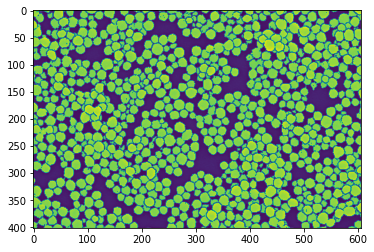

In [572]:
plt.imshow(2*(in_cell>0)+image/image.max())

In [556]:
import pandas as pd
cell_data=[]
for c in cells[:]:
    hs=c.sum(0)
    vs=c.sum(1)
    
    outer= np.outer(vs,hs)
    #plt.imshow(outer)
    #plt.show()
    #plt.close() 
    cx,cy=np.unravel_index(outer.argmax(), outer.shape)
    
    count = c.sum()
    cx,cy = (np.argwhere(c).sum(0)/count).round().astype(int)
    #print(cx,cy)
    
    nc=c.copy().astype(int)
    #nc[cx,cy]=2
    
    tm=all_dists[xc-cx:xc-cx+image.shape[0],yc-cy:yc-cy+image.shape[1]].copy()
    #tm[~c]=-10
    max_dist=tm[c].max()
    min_dist=tm[~c].min()
    area=c.sum()
    area_dist=np.sqrt(area/np.pi)
    
    cell_data.append({"center_x":cx,"center_y":cy,
                                    "max_rad":max_dist,"min_rad":min_dist,
                                    "area_rad":area_dist})
    

cell_list=pd.DataFrame(cell_data)
def _ouside(row):
    cx=row["center_x"]
    cy=row["center_y"]
    max_dist = row["max_rad"]
    #max_dist = row["min_rad"]
    return cx+max_dist>image.shape[0] or cy+max_dist>image.shape[1] or cy-max_dist<0 or cx-max_dist<0

def _not_round(row):
    return row["min_rad"]/row["max_rad"]<0.5

def _invalid(row):
    return row["not_round"] or row["outside"]

cell_list["mean_rad"]=(cell_list["min_rad"]+ cell_list["max_rad"])/2

cell_list["outside"]=cell_list.apply(_ouside,axis=1)
cell_list["not_round"]=cell_list.apply(_not_round,axis=1)
cell_list["invalid"]=cell_list.apply(_invalid,axis=1)
cell_list

center_x  center_y    max_rad  ...  outside  not_round  invalid
0           9        12  22.847319  ...     True       True     True
1           6        54  20.880613  ...     True       True     True
2          16        88  34.000000  ...     True       True     True
3           9       122   9.848858  ...     True      False     True
4           6       141  11.661904  ...     True      False     True
..        ...       ...        ...  ...      ...        ...      ...
500       397       186   8.062258  ...     True      False     True
501       397       420  18.439089  ...     True       True     True
502       396       502   8.602325  ...     True      False     True
503       400       535   7.071068  ...     True       True     True
504       401       314   4.000000  ...     True      False     True

[505 rows x 9 columns]

74.77372176503927

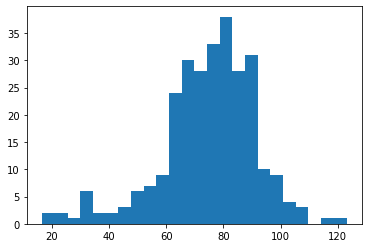

In [580]:
plt.hist(cell_list[~cell_list["invalid"]]["mean_rad"]*2*200/41,bins=24)
cell_list[~cell_list["invalid"]]["mean_rad"].mean()*2*200/41

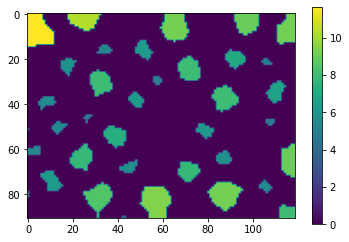

In [285]:
p=1
ks=p*2+1
k=np.ones((ks,ks))
whatershed_k=whatershed.copy()

for i in range(2):
    n_whatershed_k=convolution2d(whatershed_k, kernel=k, stride=1, padding=p,pool=np.min)
    whatershed_k[n_whatershed_k==0]=0


for i in range(20):
    n_whatershed_k=convolution2d(whatershed_k, kernel=k, stride=1, padding=p,pool=np.max)#-convolution2d(whatershed, kernel=k, stride=1, padding=p,pool=np.min)
    n_whatershed_k[whatershed_k==0]=0
    whatershed_k=n_whatershed_k
    
#n_whatershed_k=whatershed.copy()
#n_whatershed_k[whatershed_k==0]=0
#whatershed_k=n_whatershed_k

plt.imshow(whatershed_k)
plt.colorbar()
plt.show()
plt.close()

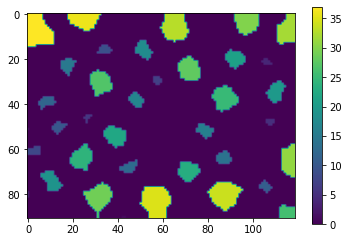

In [286]:
constant_values = whatershed_k[whatershed_k>0].min()/2
a=whatershed_k


flat=whatershed_k.flatten()
s_range=flat.argsort().argsort()

n_whatershed_k = s_range.reshape(whatershed_k.shape)
n_whatershed_k[whatershed_k==0]=0

while True:
    nn_whatershed_k = convolution2d(n_whatershed_k, kernel=k, stride=1, padding=p,pool=max_if_not_zero,constant_values=constant_values)
    n_whatershed_k_d=nn_whatershed_k-n_whatershed_k
    n_whatershed_k=nn_whatershed_k
    if n_whatershed_k_d.max()==0:
        break

uniques=np.unique(n_whatershed_k)
for i,v in enumerate(uniques):
    n_whatershed_k[n_whatershed_k==v]=i

n_whatershed_k=n_whatershed_k.astype(int)
plt.imshow(n_whatershed_k)
plt.colorbar()


In [336]:
cells=[]
for u in range(n_whatershed_k.max(),0,-1):
    ws=whatershed.copy()
    ws[n_whatershed_k!=u]=0
    ws+=mask==1
    ws[mask==2]=0
    ws=ws/(ws.max()+1)
    #ws[np.unravel_index(ws.argmax(), ws.shape)]=1
    #for i in range(int(u/4)+3):
    #    ws = convolution2d(ws, kernel=k, stride=1, padding=p,pool=max_if_not_zero,constant_values=constant_values)
    #ws=ws+(mask==2)*1/constant_values
    #ws=convolution2d(ws, kernel=k, stride=1, padding=p,pool=max_if_not_zero,constant_values=constant_values)
    cells.append(ws)

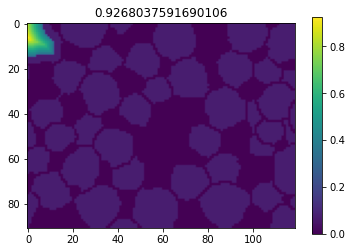

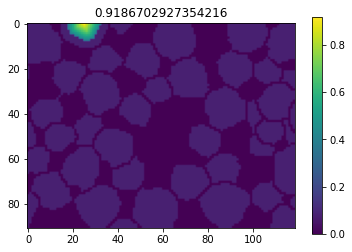

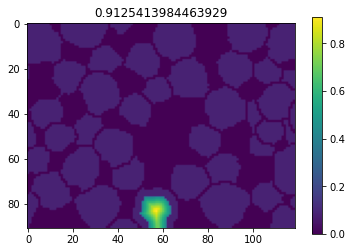

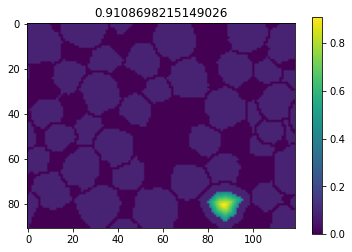

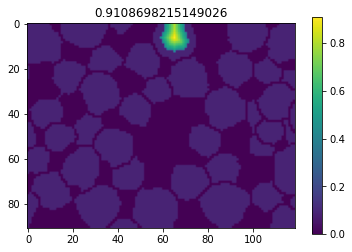

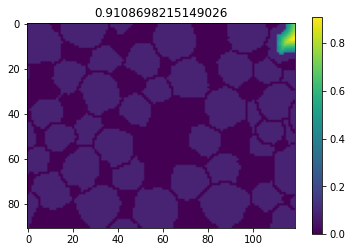

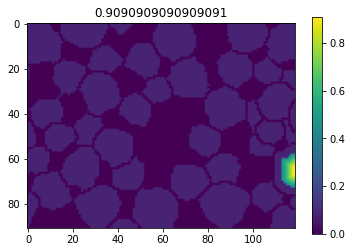

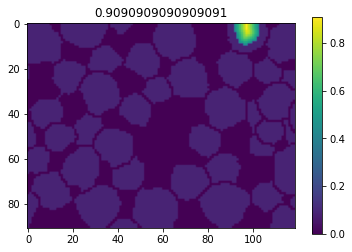

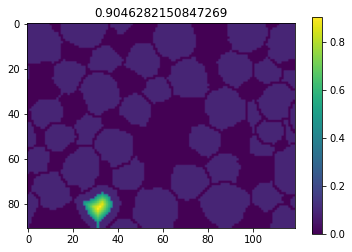

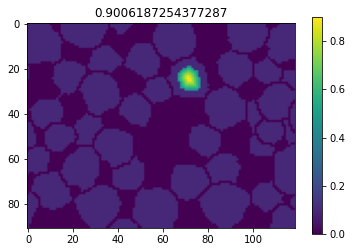

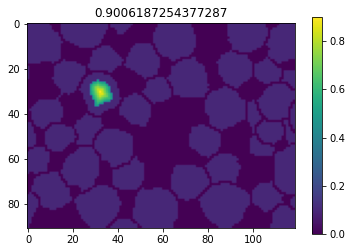

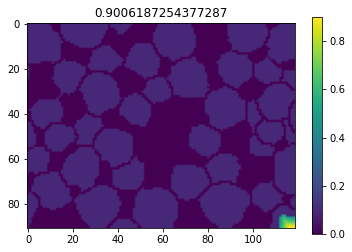

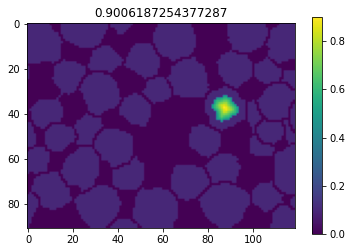

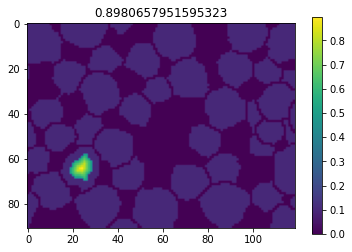

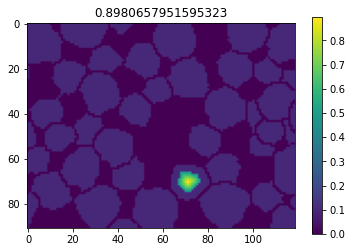

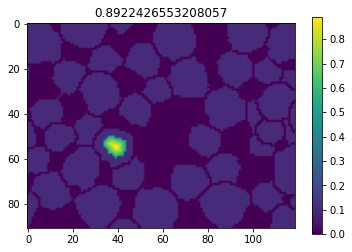

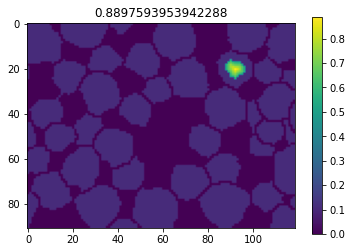

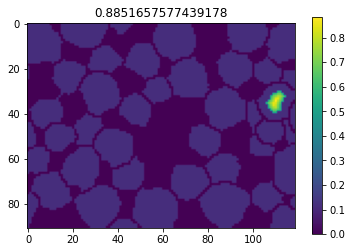

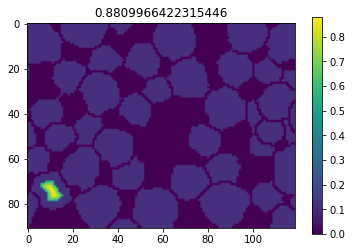

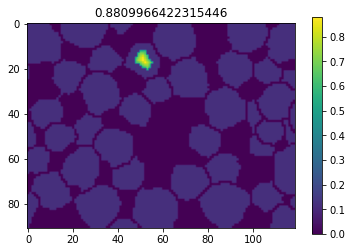

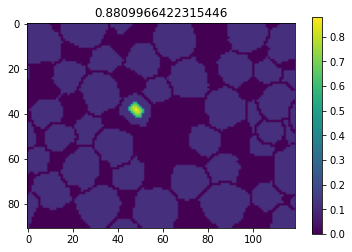

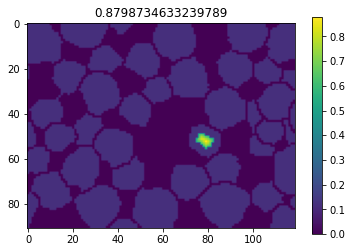

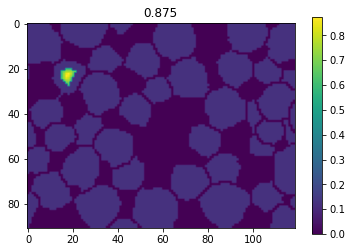

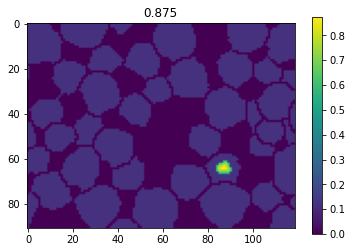

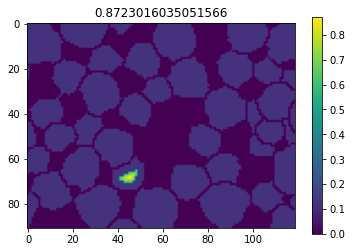

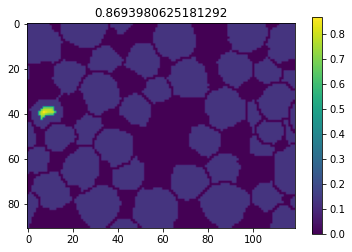

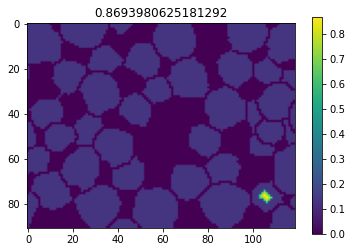

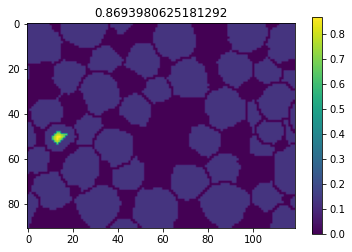

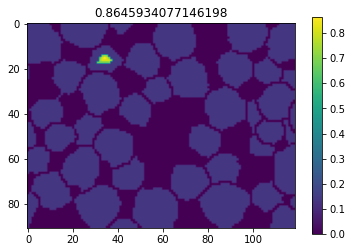

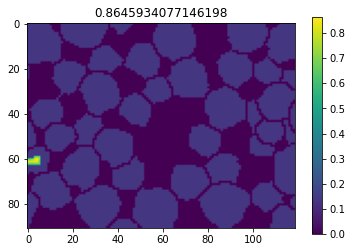

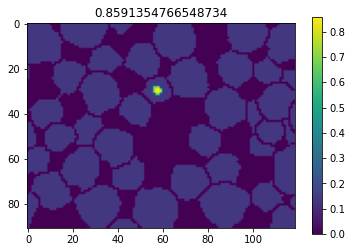

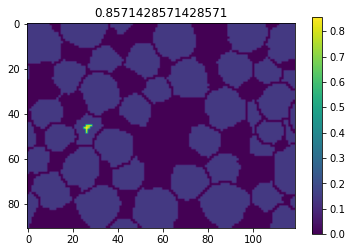

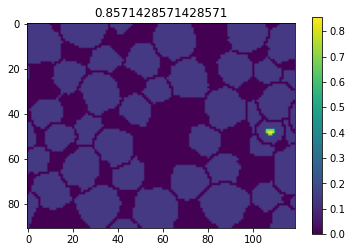

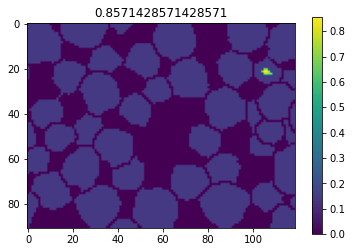

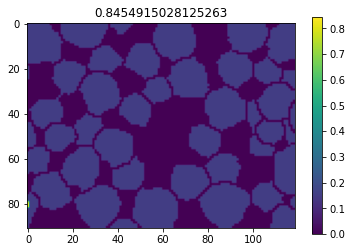

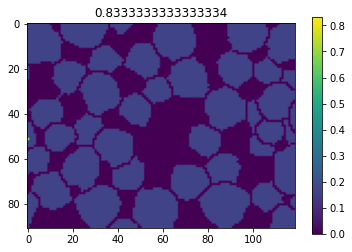

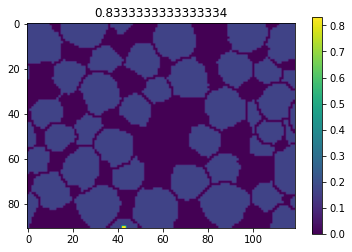

In [337]:
for cell in cells:
#    cell=cells[5]#+(mask==2)
    #cell=convolution2d(cell, kernel=k, stride=1, padding=p,pool=max_if_not_zero,constant_values=constant_values)

    cell_i=image.copy()
    cell_i=cell_i/cell_i.max()
    cell_i[:,:]=0
    cell_i+=cell#[~]/=3

    #plt.figure(dpi=200)
    plt.imshow(cell_i)
    plt.title(cell.max())
    plt.colorbar()
    plt.show()
    plt.close()


In [323]:
k

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

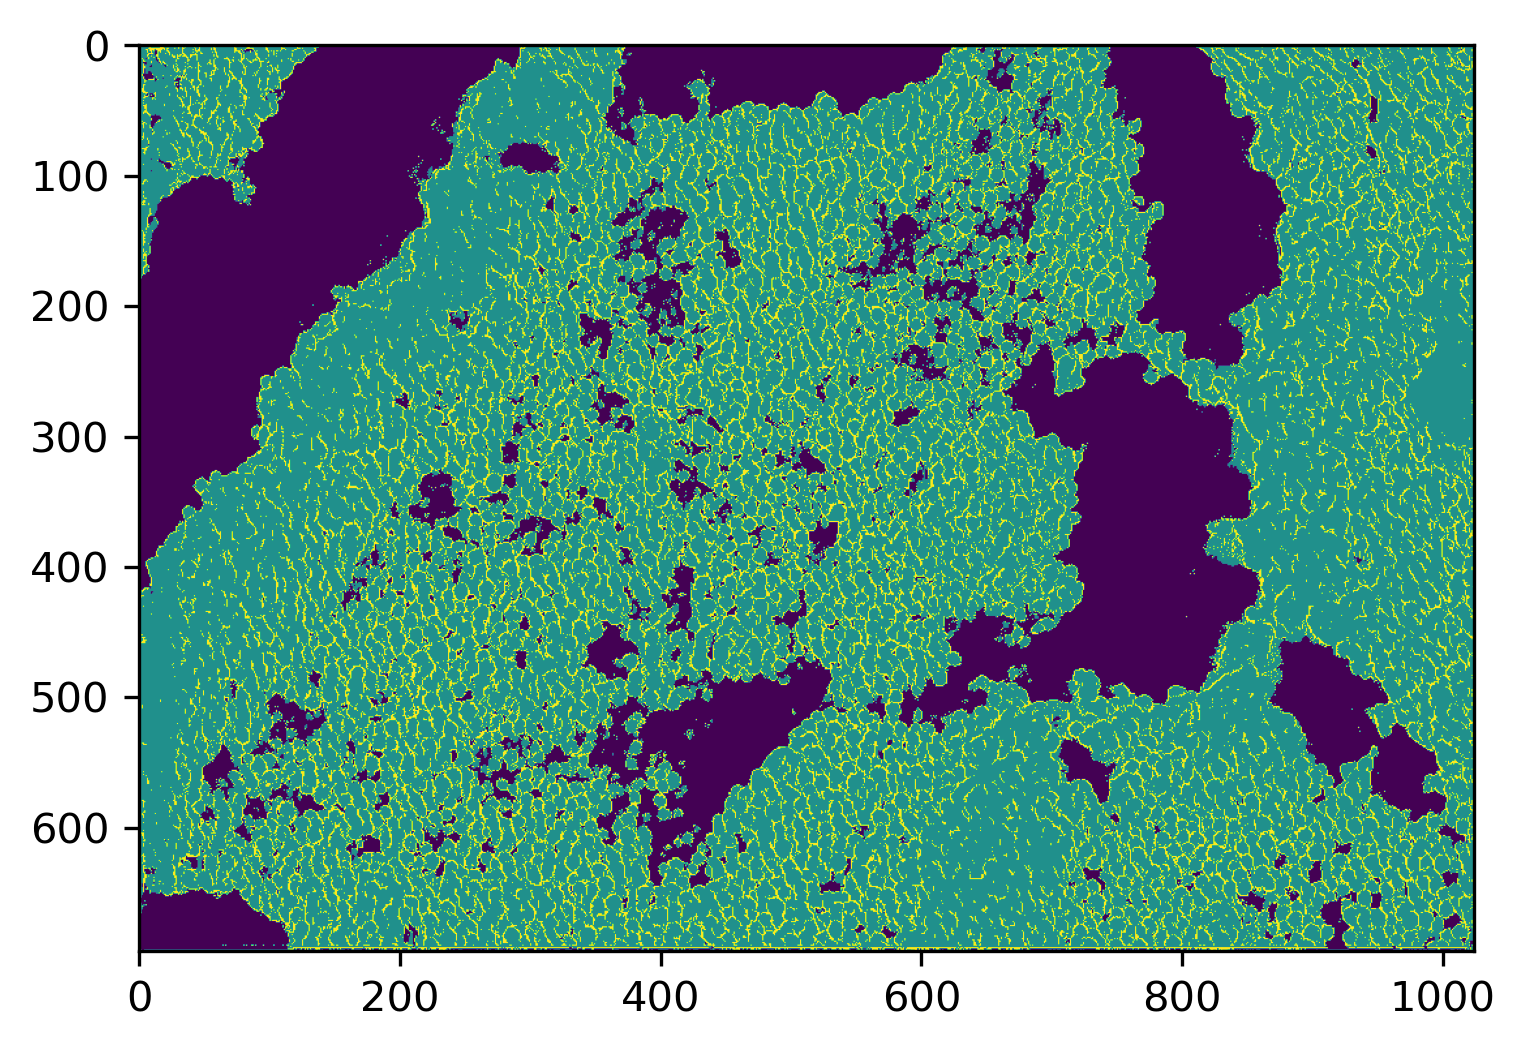

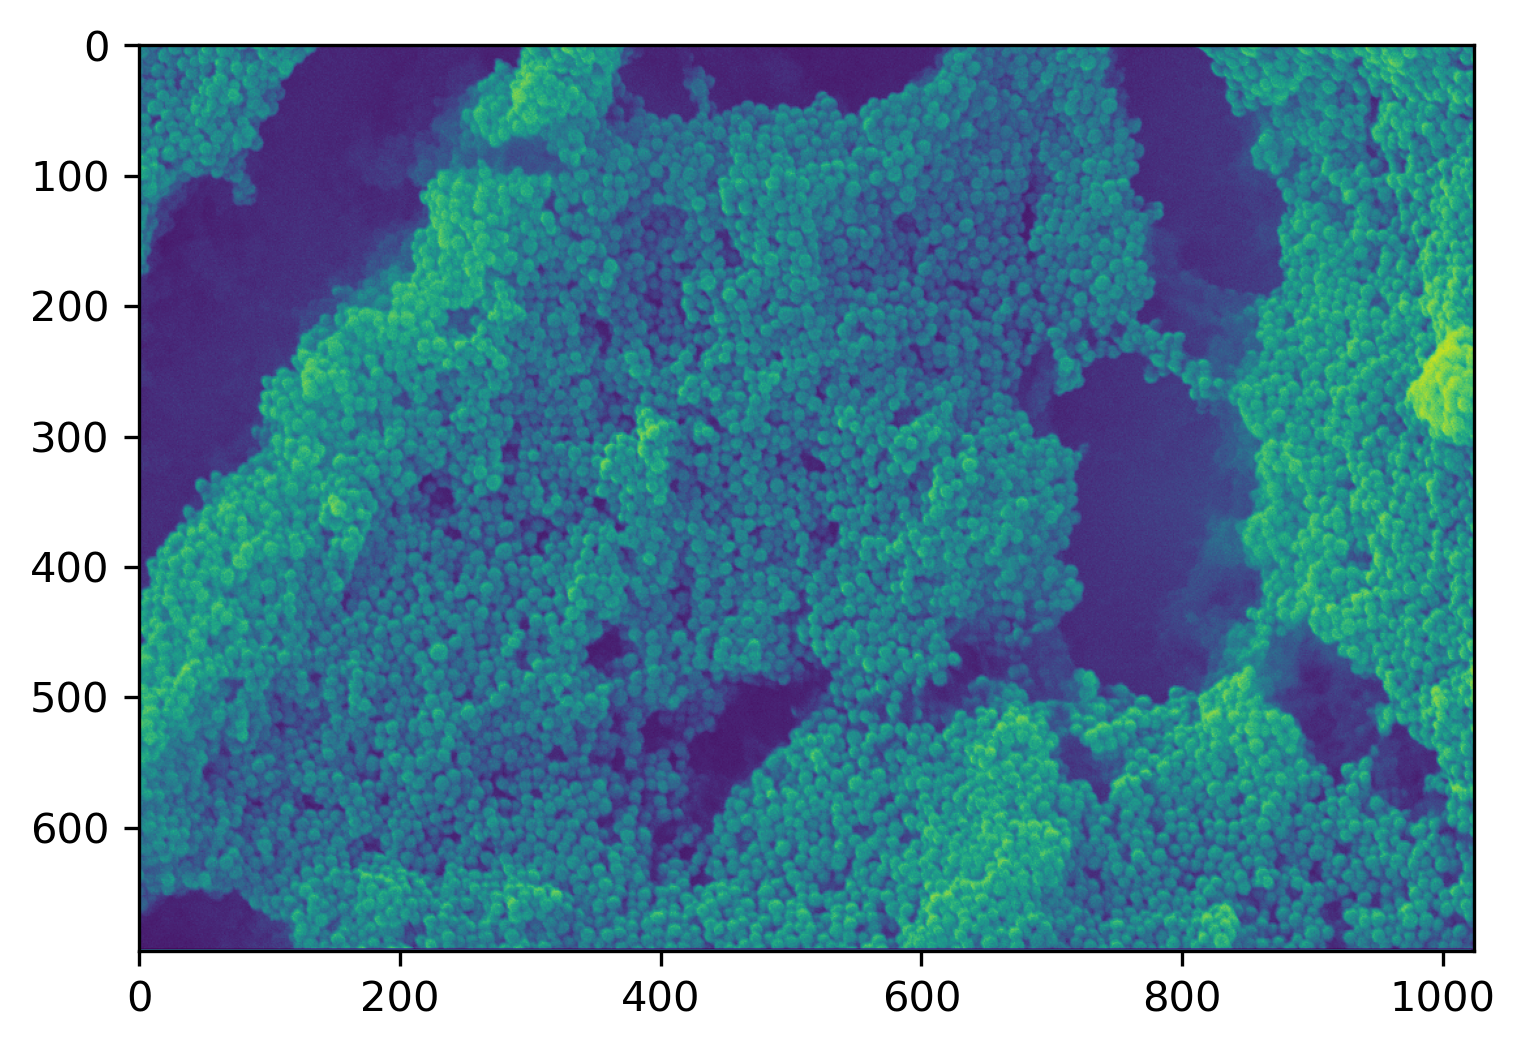

In [583]:
to_pred=np.asarray(Image.open("large.png")).mean(axis=2)
pred = model(torch.from_numpy(to_pred[None,None,:].astype(np.float32)))
pred_np=pred.detach().numpy()[0]
pred_np=pred_np.argmax(0)
#for i in pred_np[0]:
plt.figure(dpi=300)
plt.imshow(pred_np)
plt.show()
plt.close()

plt.figure(dpi=300)
plt.imshow(np.asarray(Image.open("large.png")).mean(axis=2))
plt.show()
plt.close()